In [10]:
import json 
import os
import pandas as pd
import matplotlib.pyplot as plt
import shutil

#### Identify all invalid json files

In [ ]:
'''
folder_path = "C:\\Users\\mahu123a\Documents\\3l-cvrp-classifier-work\\data\\output\classifier\\"
folder_path_invalid =r"c:\Users\mahu123a\Documents\3l-cvrp-classifier-work\data\input\3l-cvrp\test_input_invalid"

# Stelle sicher, dass der Zielordner existiert
os.makedirs(folder_path_invalid, exist_ok=True)

# Alle Dateien im Ordner durchgehen
for filename in os.listdir(folder_path):
    if filename.endswith(".json"):
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)
                # Prüfen, ob 'CP Status' existiert und 'Invalid' ist
                if data.get("CP Status") == "Invalid":
                    # Datei in den _invalid Ordner verschieben oder kopieren
                    shutil.copy(file_path, folder_path_invalid)
                    # Wenn du verschieben statt kopieren willst, nimm:
                    # shutil.move(file_path, invalid_folder)
        except Exception as e:
            print(f"Fehler beim Verarbeiten von {filename}: {e}")
'''

In [2]:
folder_path = "C:\\Users\\mahu123a\Documents\\3l-cvrp-classifier-work\\data\\output\classifier\\"
os.chdir(folder_path)

# Step 2: List all JSON files with 'join' in the filename
files = [file for file in os.listdir()]

# Step 3: Read each JSON file into a DataFram
info_df = []

volume = 60 * 25 * 30
weight = 12595

for file in files:
    with open(file, 'r') as f:
        data = json.load(f)

        total_weight = 0
        total_volume = 0
        for node in data['Nodes']:
                total_volume += node['Volume']
                total_weight += node['Weight']


        single_dict = {
            'filename': file,
            'name': data['Name'],
            'NoItems': data['NoItems'],
            'CP Time': 1800 if data['CP Time'] > 1800000 else round(data['CP Time']/1000),
            'Max Runtime': data['Max Runtime'],
            'CP Status': data['CP Status'],
            'ProblemVariant': data['Loading Parameters']['ProblemVariant'],
            'SupportArea': data['Loading Parameters']['SupportArea'],
            "Threads": data['CP Parameters']['Threads'],
            "Rel Volume" : total_volume / volume,
            "Rel Weight" : total_weight / weight
        } 

        # Append the dictionary to the list
        info_df.append(single_dict)

info_df = pd.DataFrame(info_df)
info_df.head()
# Step 4: Combine all DataFrames into one
#combined_df = pd.concat(df_list, ignore_index=True)

# Done! Print or work with the final DataFrame
#print(combined_df.head())

,filename,name,NoItems,CP Time,Max Runtime,CP Status,ProblemVariant,SupportArea,Threads,Rel Volume,Rel Weight
0,012_n020_m200_bt100_10_0_060425_sol.json,012_n020_m200_bt100_10_0_060425,98,1800,1800.0,Invalid,AllConstraints,0.75,8,0.560933,0.418282
1,012_n020_m200_bt100_10_1_060425_sol.json,012_n020_m200_bt100_10_1_060425,111,1800,1800.0,Invalid,AllConstraints,0.75,8,0.714200,0.558548
2,012_n020_m200_bt100_10_2_060425_sol.json,012_n020_m200_bt100_10_2_060425,92,1800,1800.0,Invalid,AllConstraints,0.75,8,0.524311,0.400641
3,012_n020_m200_bt100_10_3_060425_sol.json,012_n020_m200_bt100_10_3_060425,109,1800,1800.0,Invalid,AllConstraints,0.75,8,0.679289,0.508545
4,012_n020_m200_bt100_10_4_060425_sol.json,012_n020_m200_bt100_10_4_060425,98,1800,1800.0,Invalid,AllConstraints,0.75,8,0.577933,0.463682


In [3]:
len(info_df)

489

<Figure size 1000x600 with 0 Axes>

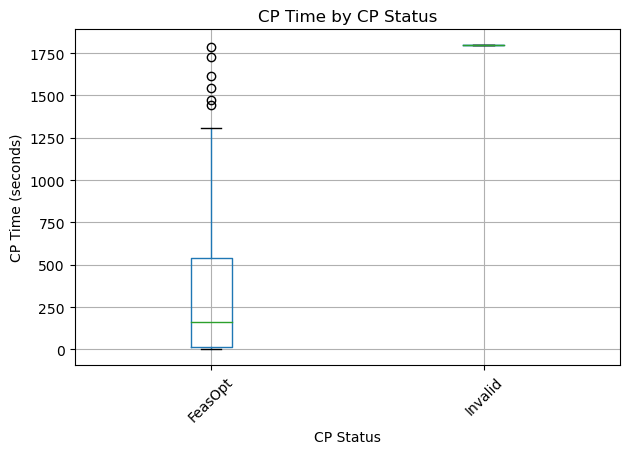

In [4]:
# Plot 1: Box plot of CP Time by CP Status
plt.figure(figsize=(10, 6))
info_df.boxplot(column='CP Time', by='CP Status')
plt.title("CP Time by CP Status")
plt.suptitle("")  # Hide automatic title
plt.xlabel("CP Status")
plt.ylabel("CP Time (seconds)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

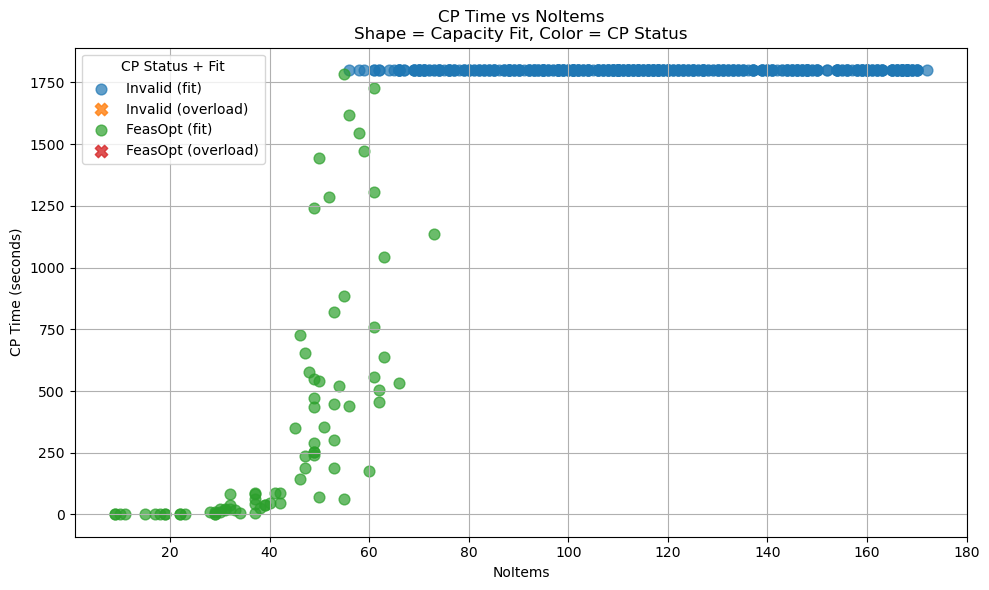

In [5]:
plt.figure(figsize=(10, 6))
statuses = info_df['CP Status'].unique()

for status in statuses:
    subset = info_df[info_df['CP Status'] == status]

    # Two marker types: overloaded vs within capacity
    within = subset[(subset['Rel Volume'] < 1) & (subset['Rel Weight'] < 1)]
    overloaded = subset[(subset['Rel Volume'] >= 1) | (subset['Rel Weight'] >= 1)]

    # Plot within capacity (circle)
    plt.scatter(
        within['NoItems'], within['CP Time'],
        label=f"{status} (fit)", marker='o', s=60, alpha=0.7
    )

    # Plot overloaded (X)
    plt.scatter(
        overloaded['NoItems'], overloaded['CP Time'],
        label=f"{status} (overload)", marker='X', s=80, alpha=0.8
    )

plt.title("CP Time vs NoItems\nShape = Capacity Fit, Color = CP Status")
plt.xlabel("NoItems")
plt.ylabel("CP Time (seconds)")
plt.legend(title="CP Status + Fit")
plt.grid(True)
plt.tight_layout()
plt.show()


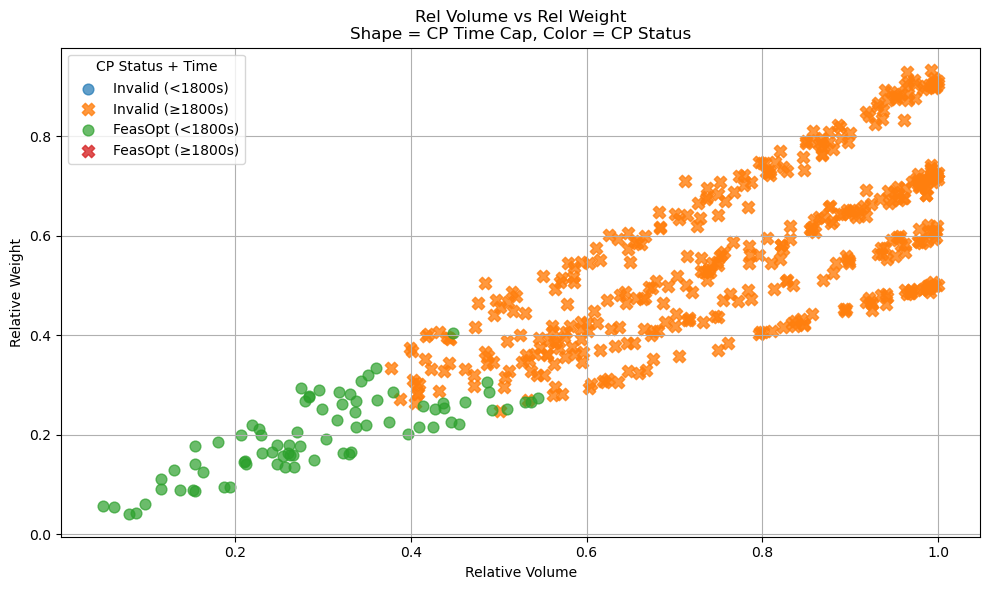

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Loop through each CP Status
for i, status in enumerate(statuses):
    df_status = info_df[info_df['CP Status'] == status]

    # Split into two groups based on CP Time
    under_1800 = df_status[df_status['CP Time'] < 1800]
    over_eq_1800 = df_status[df_status['CP Time'] >= 1800]

    # Plot under timeout (circle marker)
    plt.scatter(
        under_1800['Rel Volume'], under_1800['Rel Weight'],
        label=f"{status} (<1800s)", marker='o', s=60, alpha=0.7
    )

    # Plot timeout/maxed (X marker)
    plt.scatter(
        over_eq_1800['Rel Volume'], over_eq_1800['Rel Weight'],
        label=f"{status} (≥1800s)", marker='X', s=80, alpha=0.8
    )

plt.title("Rel Volume vs Rel Weight\nShape = CP Time Cap, Color = CP Status")
plt.xlabel("Relative Volume")
plt.ylabel("Relative Weight")
plt.grid(True)
plt.legend(title="CP Status + Time")
plt.tight_layout()
plt.show()
